### 导入数据需要的模块

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style("whitegrid")

### 导入数据

In [8]:
# balanced data，each class has the same volume of every kind of data
iris = datasets.load_iris()
# data, label = iris.data[50:, [0, 3]], iris.target[50:] * 2 - 3  # 标签变为-1,1
data, label = iris.data[50:, :], iris.target[50:] * 2 - 3  # 4 attributes
# standardizing
sc = StandardScaler()
sc.fit(data)
data = sc.transform(data)

### 分类训练集、测试集

In [9]:
test_d, test_c = np.concatenate((data[:15], data[50:65])), np.concatenate((label[:15], label[50:65]))  # 30（测试样本）
l_d, l_c = np.concatenate((data[45:50], data[95:])), np.concatenate((label[45:50], label[95:]))  # 10（标记样本）
u_d = np.concatenate((data[15:45], data[65:95]))  # 60（无标记样本）
lu_d = np.concatenate((l_d, u_d))  #混合样本
n = len(l_d)+len(u_d)
# u_d, u_c = np.concatenate((data[20:50], data[70:])), np.concatenate((label[20:50], label[70:]))  # 60

### 模型训练

In [10]:
clf1 = svm.SVC(C=1,kernel='linear')
clf1.fit(l_d, l_c)
clf0 = svm.SVC(C=1,kernel='linear')
clf0.fit(l_d, l_c)
lu_c_0 = clf0.predict(lu_d) 

In [11]:
u_c_new = clf1.predict(u_d)  # the pseudo label for unlabelled samples
cu, cl = 0.001, 1    #设置参数
sample_weight = np.ones(n)
sample_weight[len(l_c):] = cu
id_set = np.arange(len(u_d))
while cu < cl:
    lu_c = np.concatenate((l_c, u_c_new))  # 70
    clf1.fit(lu_d, lu_c, sample_weight=sample_weight)
    while True:
        u_c_new = clf1.predict(u_d)  # the pseudo label for unlabelled samples
        u_dist = clf1.decision_function(u_d)  # the distance of each sample
        norm_weight = np.linalg.norm(clf1.coef_)  # norm of weight vector
        epsilon = 1 - u_dist * u_c_new * norm_weight

        plus_set, plus_id = epsilon[u_c_new > 0], id_set[u_c_new > 0]  # positive labelled samples
        minus_set, minus_id = epsilon[u_c_new < 0], id_set[u_c_new < 0]  # negative labelled samples
        plus_max_id, minus_max_id = plus_id[np.argmax(plus_set)], minus_id[np.argmax(minus_set)]
        a, b = epsilon[plus_max_id], epsilon[minus_max_id]

        if a > 0 and b > 0 and a + b > 2:
            u_c_new[plus_max_id], u_c_new[minus_max_id] = -u_c_new[plus_max_id], -u_c_new[minus_max_id]
            lu_c = np.concatenate((l_c, u_c_new))
            clf1.fit(lu_d, lu_c, sample_weight=sample_weight)
        else:
            break
    cu = min(cu * 2, cl)
    sample_weight[len(l_c):] = cu

### 模型预测 得分

In [12]:
lu_c = np.concatenate((l_c, u_c_new))
test_c1 = clf0.predict(test_d)
test_c2 = clf1.predict(test_d)
score1 = clf0.score(test_d,test_c)
score2 = clf1.score(test_d,test_c)

### 绘制结果图

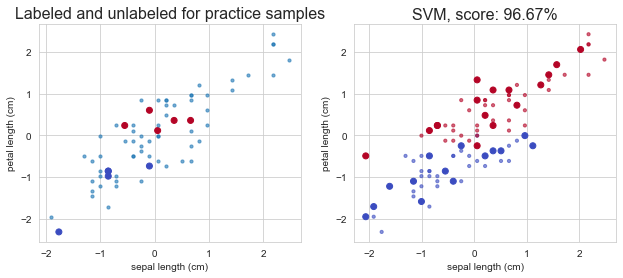

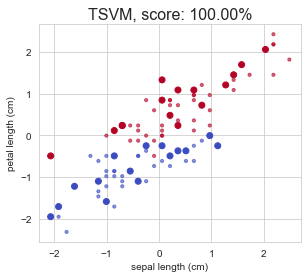

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
ax.scatter(l_d[:,0],l_d[:,2],c=l_c,marker='o',cmap=plt.cm.coolwarm)
ax.scatter(u_d[:,0], u_d[:,2],marker='o',s=10,cmap=plt.cm.seismic,alpha=.6)
ax.set_title('Labeled and unlabeled for practice samples',fontsize=16)
ax1 = fig.add_subplot(132)
ax1.scatter(test_d[:,0],test_d[:,2],c=test_c1,marker='o',cmap=plt.cm.coolwarm)
ax1.scatter(lu_d[:,0], lu_d[:,2], c=lu_c_0, marker='o',s=10,cmap=plt.cm.coolwarm,alpha=.6)
ax1.set_title('SVM, score: {0:.2f}%'.format(score1*100),fontsize=16)

fig = plt.figure(figsize=(16,4))
ax2 = fig.add_subplot(133)
ax2.scatter(test_d[:,0],test_d[:,2],c=test_c2,marker='o',cmap=plt.cm.coolwarm)
ax2.scatter(lu_d[:,0], lu_d[:,2], c=lu_c, marker='o',s=10,cmap=plt.cm.coolwarm,alpha=.6)
ax2.set_title('TSVM, score: {0:.2f}%'.format(score2*100),fontsize=16)
for a in [ax,ax1,ax2]:
    a.set_xlabel(iris.feature_names[0])
    a.set_ylabel(iris.feature_names[2])
plt.show()